In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import matplotlib.pyplot as plt
import scipy                  # http://scipy.org/
from scipy import signal

from scipy.fftpack import fft, fftfreq
from time import time

from IPython.display import Image  


from matplotlib import animation
from IPython.display import HTML

%matplotlib inline
#%matplotlib notebook
params = {'legend.fontsize': 14,
          'figure.figsize': (8, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize':14,
         'ytick.labelsize':14}

plt.rcParams.update(params) 

In [2]:
def myVector(a,w,d,n):
    U = a*np.sin( w*n/np.pi+d)  
    V = a*np.cos( w*n/np.pi+d)     
    return U,V

def oneTone(a,w,d,n):
    Up,Vp = myVector(a, w,d,n) 
    Un,Vn = myVector(a,-w,d,n) 
    return Up,Vp,Un,Vn 



def mixTone(a,wa,b, wb, n):
    Uap,Vap,Uan,Van = oneTone(a*b/2, wb + wa,0,n)
    Ua = Uap + Uan
    Va = Vap + Van

    Ubp,Vbp,Ubn,Vbn = oneTone(a*b/2,wb - wa ,0,n)
    Ub = Ubp + Ubn
    Vb = Vbp + Vbn

    return Ua,Va,Ub,Vb 


## Modulador Amstrong de PM.
 
    
En 1933, Edwin H. Armstrong patentó un método para generar modulación de frecuencia de señales de radio.  

Las primeras emisoras utilizaron la modulación de amplitud porque era más fácil de generar que la modulación de frecuencia y porque los receptores eran más simples de hacer. 


![ex 2.13](amstrongPM.png)

Armstrong se dio cuenta de que, si bien una señal de frecuencia modulada tendría un ancho de banda infinito, solo los primeros conjuntos de bandas laterales serían significativos; el resto podría ser ignorado. 
Un ancho de banda de canal de voz modulado en amplitud sería de aproximadamente $6 kHz$; un ancho de banda de canal de voz modulado en frecuencia común podría ser de $15 kHz$.


El método Armstrong comienza generando una señal portadora a una frecuencia muy baja, digamos $500 kHz$. 
Esta frecuencia está por debajo de la banda de transmisión de AM y muy por debajo de la banda de transmisión de FM actual de $88 MHz$ a $108 MHz$. 
Esta señal portadora se inyecta a dos etapas en el transmisor: un modulador balanceado y un mezclador.

El modulador balanceado mezcla la señal de audio y la portadora de radiofrecuencia, pero suprime la portadora, dejando solo las bandas laterales (DBLSC). 

En el método Armstrong, la señal de audio y la señal portadora de radiofrecuencia se aplican al modulador balanceado para generar una señal portadora suprimida de doble banda lateral. La fase de esta señal de salida se desplaza 90 grados con respecto a la portadora original. La salida del modulador balanceado puede adelantar o retrasar la fase de la portadora. La señal de doble banda lateral y la señal portadora original se inyectan luego al mezclador, y la portadora original, 90 grados fuera de fase, se suma luego. 
La salida del mezclador es una señal de frecuencia modulada.

Reinsertar la portadora sin el cambio de fase produce una señal de AM. Reinsertar la portadora con el desplazamiento de fase de 90 grados produce una señal PM. Si la modulante se integra antes de aplicarse al modulador de fase resultante, este resulta en una señal de FM.

Uno de los problemas con el método Armstrong es que la desviación de frecuencia (la cantidad de modulación) debe mantenerse pequeña para minimizar la distorsión. 
La desviación máxima es una fracción de $1 kHz$, pero la transmisión FM requiere una desviación de $75 kHz$ y una desviación típica del canal de voz FM es de $5 kHz$. 

Para resolver este problema, Armstrong multiplicó la señal muchas veces a una frecuencia más alta para obtener la desviación necesaria. Por ejemplo, para generar una señal FM con una desviación de $5 kHz$ a $146,94 MHz$, el transmisor generaría una señal a $6,1225 MHz$ con solo una desviación de $0,2 kHz$ y luego multiplicaría la señal $24 veces$.

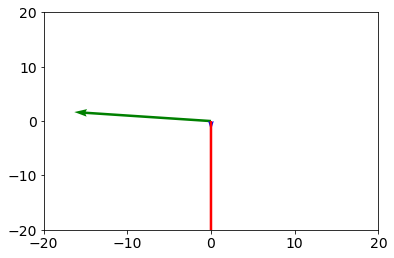

In [3]:
a  = 0.1
wa = 2*np.pi/200
b  = 10
wb = 2*np.pi/50

U  = [0,0,0]
V  = [0,0,0]

fig, ax = plt.subplots(1,1)
Q       = ax.quiver([0,0,0],[0,0,0], U, V,  color=['g','b','r'], units= 'xy', scale=1, pivot ='tail')

ax.set_xlim(-20,  20)
ax.set_ylim(-20,  20)

def update_quiver(num, Q, a, b, wa, wb):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """
    Ucp,Vcp,Ucn,Vcn= oneTone(b,wb,0,num)
    Uc = Ucn + Ucp
    Vc = Vcn + Vcp
    Ump,Vmp,Umn,Vmn= oneTone(1,wa,0,num)
    Um = Umn + Ump
    Vm = Vmn + Vmp
    Ucp,Vcp,Ucn,Vcn= oneTone(b,wb,np.pi/2,num)
    Uc90 = Ucn + Ucp
    Vc90 = Vcn + Vcp
    Ua,Va,Ub,Vb  = mixTone(a,wa,b, wb, num)
    
    U = [Ua+Ub+Uc90,Um,Uc]
    V = [Va+Vb+Vc90,Vm,Vc]
    
    Q.set_UVC(U,V)
    return Q,

# you need to set blit=False, or the first set of arrows never gets
# cleared on subsequent frames
anim = animation.FuncAnimation(fig, update_quiver, fargs=(Q, a,b,wa,wb), interval=20, frames=400,blit=True)

HTML(anim.to_html5_video())

In [4]:
def modPM(time, Am, fm, Ac, fc, output='PM', showme = 'time'):
    dt = time[1] - time[0] 
    Sc   = Ac*np.cos(2*np.pi*fc*time)
    Sc90 = Ac*2*np.cos(2*np.pi*fc*time - np.pi/2)
    Sm   = Am*np.cos(2*np.pi*fm*time)
    
    Spm  = (Sc*Sm)+Sc90
    
    if   output == 'PM'  : Smo = Spm
    elif output == 'Sm'  : Smo = Sm
    elif output == 'Sc'  : Smo = Sc
    elif output == 'Sc90': Smo = Sc90
    else                 : Smo = Spm
        
    if showme == 'time':
        plt.plot(time, Smo, 'r-')
        plt.xlim([0,max(time)/2])
        plt.ylabel('PM(t)/V')
        plt.xlabel('Time/s')
        plt.show()    
    else :
        Y = fft(Smo) / len(Smo)  # Normalizada
        frq = fftfreq(len(Smo), dt)  # Recuperamos las frecuencias
        plt.plot(frq, np.abs(Y), 'ro-' )  # Representamos la parte imaginaria
        plt.ylim(-0.1, 1.1)
        plt.xlabel('$Frecuencia/Hz$')
        plt.ylabel('$Abs(Y)$')
        plt.xlim([-120,120])
        plt.grid()
        plt.show()

        
# Ejemplo FM en el tiempo
# modulante
fm    = 5 #Hz
T     = 10/fm
Am    = 0.5  
# carrier
fc    = 100
Ac    = 1
# defino el sampleo
Fs = 20*fc #Sps 
dt = 1/Fs
# vector de tiempo 
t  = np.arange(0., T, dt)

In [5]:
%matplotlib inline
interact(modPM, time = fixed(t), Am=fixed(Am), fm=fixed(fm), Ac=fixed(Ac), fc=fixed(fc),
         output = ['Sm','Sc','Sc90', 'PM'], showme = ['time','freq']  )

interactive(children=(Dropdown(description='output', index=3, options=('Sm', 'Sc', 'Sc90', 'PM'), value='PM'),…

<function __main__.modPM(time, Am, fm, Ac, fc, output='PM', showme='time')>


## Circuito practico


![ex 2.13](amstrongPMsch.png)


## Circuito RF

![ex 2.13](amstrongPMRF.png)



$$-v_i (S C_1 - g_m) + v_o [\frac{1}{SL} + \frac{1}{R_L} + S(C+C_1) ] = 0$$


$$\frac{v_o}{v_i}|_{j\omega} = A(j\omega) = - \frac{g_m + j \omega C_1}{\frac{1}{R_L} + j [\omega (C+C_1)-\frac{1}{\omega L}]}$$


$$|A(j\omega)| = \sqrt{ \frac{g_m^2 +  (\omega C_1)^2}{ (\frac{1}{R_L})^2 + (\omega (C+C_1)-\frac{1}{\omega L})^2}}$$


En resonancia 

$$\omega = \frac{1}{\sqrt{(C+C_1) \cdot L}}$$


$$A(j\omega) = - R_L (g_m + j \omega C_1)$$


$$|A(j\omega)| = R_L \sqrt{ g_m^2 +  (\omega C_1)^2 }$$


$$\varphi (A(j\omega)) = arctg(-\frac{\omega C_1}{g_m})$$

$$\Delta \varphi = \frac{d \varphi }{d g_m} \Delta g_m$$

$$\frac{d \varphi }{d g_m} = \frac{\omega C_1}{g_m^2 + (\omega C_1)^2}$$

$$\Delta \varphi = \frac{\omega C_1}{g_m^2 + (\omega C_1)^2} \Delta g_m $$



# Modulador Fase Beleskas



## Circuito practico


![ex 2.13](BeleskasPMsch.png)


## Circuito RF

![ex 2.13](BeleskasPMRF.png)

Suponiendo $C_1 = C_2$ y $R_L = Inf$.

$$v_1 = v_i - (g_m \cdot v_1) \cdot \frac{1}{SC_1} $$

$$v_1 = v_i \frac{1}{1+   \frac{g_m}{SC_1}} $$


$$v_o = v_1 - (g_m \cdot v_1) \cdot \frac{1}{SC_1} = v_1  (1 - \frac{g_m}{SC_1})$$

$$v_o = v_i \frac{1}{1+   \frac{g_m}{SC_1}}  (1 - \frac{g_m}{SC_1})$$


$$\frac{v_o}{v_i} =  \frac{SC_1 - g_m}{SC_1 + g_m}$$


$$|A(j\omega)| =  \sqrt{ \frac{(\omega C_1)^2  + g_m^2}{(\omega C_1)^2  + g_m^2}}= 1$$


$$\varphi (A(j\omega)) = arctg(-\frac{\omega C_1}{g_m}) - arctg(\frac{\omega C_1}{g_m}) = -2 arctg(\frac{\omega C_1}{g_m}) $$

$$\Delta \varphi = \frac{d \varphi }{d g_m} \Delta g_m$$

$$\frac{d \varphi }{d g_m} = \frac{2 \omega C_1}{g_m^2 + (\omega C_1)^2}$$

$$\Delta \varphi = \frac{2 \omega C_1}{g_m^2 + (\omega C_1)^2} \Delta g_m $$


# Ejercicio

El FET de la figura constituye un modulador de fase tipo Armstrong precedido por un circuito integrador realizado con un amplificador operacional ideal.

![ex 2.13](armstrongEJ.png)

La próxima etapa, que no se muestra en la figura, es un circuito multiplicador realizado en base a un PLL con posibilidad de multiplicar por cualquier número entero entre $1$ y $10.000$ (Índice programable) para todas las frecuencias de interés. 

La $Z_{in}$ del multiplicador está representada por $R_L$.

A la salida del multiplicador hay una señal con $f_c = 150 MHz$ y  $\Delta f_c= 5KHz$ que a través de etapas amplificadoras se envía a antena.



El FET es de transferencia cuadrática  

$$I_D = I_{DSS}(1-\frac {V_{gs}} {V_{c}} )^2$$  

$$Y_{22}=100 \mu S$$

El tanque de salida trabaja con $Q_c=10$ y la bobina $L$ sintoniza, a la frecuencia del oscilador, con los capacitores $C_1$ y $C$ en paralelo.

Los capacitores de acople $C_A$, son un cortocircuito para todas las frecuencias de interés.

El choque $L_{CH}$ es un circuito abierto a la frecuencia del oscilador y un corto a las frecuencias de modulación.

Los elementos reactivos no tienen pérdidas.

El FET está polarizado de forma tal que $G_m(pol)= \frac{G_m(máxima)}{2}$.

El oscilador entrega una señal senoidal pura  de amplitud 1Vpico independiente de la impedancia de carga ($R_{int.oscil}= 0$).

La señal de modulación es una sinusoide pura de $V_{mod}= 1V_{pico}$ y frecuencia $f_{mod} = 1 KHz$.

$$R_1=R_2=4,7 K\Omega$$	 

$$R_L=1 K\Omega$$ 	

$$C_2=0,1\mu F$$	

$$I_{dss}=10 mA$$	

$$V_c= -5 V$$

$C_1$ se ha elegido para que maximice la sensibilidad de modulación $\frac{\Delta \varphi}{\Delta g_m}$.


Determinar:


1. $V_{ref}$

2. $\Delta g_m$


3. N: índice de multiplicación del multiplicador (adoptar el entero más cercano al valor de cálculo) y frecuencia del oscilador $f_{osc}$

4. $\Delta \varphi$ y $ \Delta f$ sobre $R_L$

5. $C$


6. Se cambia la frecuencia de salida del $T_x$ para que opere alrededor de los $30 MHz$ (Valor no exacto dependiente de los N posibles) manteniéndose el  $ \Delta f$= 5Khz. 
Esto se logra cambiando solamente el índice N del multiplicador y el valor de $R_1$, el resto de los componentes y frecuencia del oscilador permanecen sin cambios.  
Determinar los nuevos valores $N^{\prime}$ y $R_1^{\prime}$ 

7. En las condiciones del ítem 6 determinar el porcentaje de modulación de AM sobre RL

8. Repuesto el circuito a las condiciones iniciales del problema se cambia $V_{mod}$ para operación multitonal. $V_{mod}$ pasa a estar constituida por dos generadores senoidales en serie. 
Cada uno de ellos entrega $0,5 V_{pico}$ con frecuencias de $2 KHz$ y $5 KHz$ respectivamente. Determinar el  máximo a la salida sobre $R_L$.



# 1. Vref



In [32]:
# Calculo de Re
# Datos

#FET
Idss = 10e-3
Vc   = -5
Vg   =  0


#integrador
R1   = 4.7e3
R2   = 4.7e3
C    = 100e-9
fmod = 1e3 
vmod = 1

#Salida
fc = 150e6

# gm
def gmVgs(Vgs, Idss, vc):
    return -2 * Idss/Vc *(1-(Vgs/Vc))

print('gmax= {:1.3f} mS'.format(gmVgs(0,Idss,Vc)/1e-3))

Vgso = -(0.5 - 1)*Vc   
print('Vgso= {:1.3f} V'.format(Vgso))
print('gmo= {:1.3f} mS'.format(gmVgs(Vgso,Idss,Vc)/1e-3))

gmo   = gmVgs(Vgso,Idss,Vc)
Vref = Vgso 

print('Vref= {:1.3f} V'.format(Vref))


gmax= 4.000 mS
Vgso= -2.500 V
gmo= 2.000 mS
Vref= -2.500 V


# 2. $\Delta g_m$

![ex 2.13](armstrongInt.png)

$$Z_1 = R_1$$

$$Z_2 = \frac{R_2}{1 + S C_2 R_2}$$

$$A_v = -\frac{Z_2}{Z_1} = -\frac{R_2}{R_1} \frac{1}{1+S C_2 R_2}$$ 

$$A_v = -\frac{R_2}{R_1} \frac{1}{1+j \omega C_2 R_2}$$ 

$$\omega_p = \frac{1}{C_2 R_2}$$ 

$$f_p = \frac{1}{2 \pi C_2 R_2}$$

## $\Delta g_{m}$

$$\Delta g_{m} = -\frac{2 I_{dss}}{v_c^2} \Delta v_{gs}$$


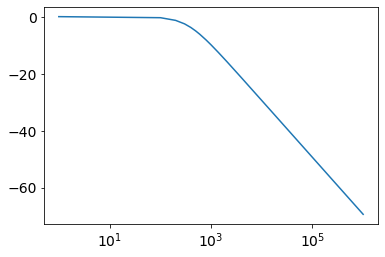

Dvg = 0.32 V
Dgm = 256.59 uS


In [33]:
def Avint(R1,R2,C,f): 
    return -R2/R1 * (1/(1+1j*2*np.pi*f*R2*C))

freq = np.arange(1,10e5,100)
plt.semilogx(freq, 20*np.log10(abs(Avint(R1,R2,C,freq))) )
plt.show()


Dvgs = abs(Avint(R1,R2,C,fmod))*vmod 
print('Dvg = {:1.2f} V'.format(abs(Dvgs) ) )

Dgm = -2 * Idss/Vc**2 * Dvgs
print('Dgm = {:1.2f} uS'.format(abs(Dgm/1e-6) ) )


# 4. N: índice de multiplicación del multiplicador (adoptar el entero más cercano al valor de cálculo) y frecuencia del oscilador $f_{osc}$

$$\Delta \varphi = \frac{\omega C}{g_{mo}^2 + (\omega C)^2} \Delta g_{mo} $$


$$\frac{d \varphi}{d C} =   \frac{g_{mo}^2-(\omega C)^2}{(g_{mo}^2 + (\omega C)^2)^2} = 0$$

$$g_{mo}^2-(\omega C)^2 = 0$$

$$\omega C =  g_{mo}$$

$$\Delta \varphi = \frac{2 \omega C_1}{g_{mo}^2 + (\omega C_1)^2} \Delta g_m $$

$$\Delta \varphi = \frac{1}{g_{mo}} \Delta g_m $$


In [34]:
Dphi = 1/(2*gmo) *Dgm 

print('Dphi = {:1.3f} rad'.format(Dphi) )

print('Dphi = {:1.3f} grados'.format(Dphi*180/np.pi) )

Df = fmod*Dphi

print('Df = {:1.3f} '.format(Df) )


N = 5000/abs(Df)

print('N = {:1.0f} '.format(N) )

fosc = fc/N

print('fosc = {:1.2f} MHz'.format(fosc/1e6) )


Dphi = -0.064 rad
Dphi = -3.675 grados
Df = -64.147 
N = 78 
fosc = 1.92 MHz


# 3. Relación entre $\Delta \varphi$ y $\Delta f$


$$\omega_i(t) = \omega_c + \Delta \omega(t)$$

$$\omega_i(t) = \omega_c + \Delta \omega \cdot \cos(\omega_m t)$$


$$\varphi = \int \omega_i(t) dt$$ 

$$\varphi = \omega_c t +  \frac{\Delta \omega_m}{\omega_m} \cdot \sin(\omega_m t)$$ 

$$\Delta \varphi = \frac{\Delta \omega_m}{\omega_m} = \frac{\Delta f_m}{f_m}$$


In [35]:
Df = fmod*Dphi

print('Df = {:1.3f} '.format(Df) )

Df = -64.147 


# 5. $C$

$$\Delta \varphi = \frac{\omega C}{g_{mo}^2 + (\omega C)^2} \Delta g_{mo} $$


$$\frac{d \varphi}{d C} =   \frac{g_{mo}^2-(\omega C)^2}{(g_{mo}^2 + (\omega C)^2)^2} = 0$$

$$g_{mo}^2-(\omega C)^2 = 0$$

$$C = \frac{g_{mo}}{ \omega} $$



In [36]:

C = gmo/(2*np.pi*fosc) 

print('C= {:1.3f} pF'.format(C/1e-12))



C= 165.405 pF


# 6. Se cambia la frecuencia de salida del $T_x$ para que opere alrededor de los $30 MHz$ (Valor no exacto dependiente de los N posibles) manteniéndose el  $ \Delta f$= 5Khz.  Esto se logra cambiando solamente el índice N del multiplicador y el valor de $R_1$, el resto de los componentes y frecuencia del oscilador permanecen sin cambios.   Determinar los nuevos valores $N^{\prime}$ y $R_1^{\prime}$ 


$$\Delta \varphi = \frac{\Delta \omega_m}{\omega_m} = \frac{\Delta f_m}{f_m}$$

$$\Delta g_m  = \Delta \varphi \cdot \frac{g_m^2 + (\omega C_1)^2}{2 \omega C_1} $$

$$\Delta v_{gs} = -\Delta g_{m}  \frac{v_c^2}{2 I_{dss}} $$

$$A_v = -\frac{R_2}{R_1} \frac{1}{1+j \omega C_2 R_2}$$ 



In [44]:
Np    = 30e6/fosc
print('N={:1.0f}'.format(Np))


Dfp   = 5000/Np

Dphip = Dfp/fmod
print('Dphi ={:1.3e} rad'.format(Dphip))
print('Dphi ={:1.3f} '.format(Dphip*180/np.pi))


Dgmp   = -Dphip * 2*gmo 

Dvgsp  = Dgmp * Vc**2 /(2 * Idss) 

print(Dvgsp)

Avp = abs(Dvgsp)

R1p = R2/Avp * abs(1/(1+1j*2*np.pi*fmod*R2*C))


print('R1={:1.0f}'.format(R1p))

N=16
Dphi =3.207e-01 rad
Dphi =18.377 
-1.6036862016020157
R1=2931


# 7. En las condiciones del ítem 6 determinar el porcentaje de modulación de AM sobre RL

$$A(j\omega) = - R_L (g_m + j \omega C_1)$$

$$|A(j\omega)| = R_L \sqrt{ g_m^2 +  (\omega C_1)^2 }$$

$$m = \frac{V_{max}-V_{min}}{V_{max}+V_{min}}$$

In [59]:
RL = 1e3
print(gmo)

gmmax = (gmo-Dgmp)
print(gmmax)
Avmax =   RL * 2**0.5 * gmmax
print(Avmax)


gmmin  = (gmo+Dgmp)
print(gmmin)
Avmin =   RL * 2**0.5 * gmmin
print(Avmin)

m = (Avmax-Avmin)/(Avmax+Avmin)
print(m)

0.002
0.0032829489612816124
4.642790945623122
0.0007170510387183875
1.0140633038692588
0.6414744806408063


# 8. Repuesto el circuito a las condiciones iniciales del problema se cambia $V_{mod}$ para operación multitonal. $V_{mod}$ pasa a estar constituida por dos generadores senoidales en serie.  Cada uno de ellos entrega $0,5 V_{pico}$ con frecuencias de $2 KHz$ y $5 KHz$ respectivamente. Determinar el  máximo a la salida sobre $R_L$.
